## Sentiment Analysis for Korean Movie Review Data

### 1. Load Data and EDA

In [1]:
import pandas as pd

movie_data = pd.read_csv("~/Downloads/movie_data.csv", header=None)

In [2]:
movie_data.head()

,0,1,2
0,오~~ 종합선물셋트,9,인피니티 워
1,크레딧 올라올때부터 충격먹었어요 ㅋㅋㅋㅋ 나중에 더큰 활약기대하겠습니다! 와칸다포에...,10,인피니티 워
2,이제 남은건타노스 밖에,10,인피니티 워
3,타노스는 발암물질이다.,9,인피니티 워
4,정말재미있게봤습니다,10,인피니티 워


In [3]:
# dataframe의 column명을 지정합니다.
movie_data.columns = ["review", "score", "movie_title"]

In [4]:
movie_data.head()

,review,score,movie_title
0,오~~ 종합선물셋트,9,인피니티 워
1,크레딧 올라올때부터 충격먹었어요 ㅋㅋㅋㅋ 나중에 더큰 활약기대하겠습니다! 와칸다포에...,10,인피니티 워
2,이제 남은건타노스 밖에,10,인피니티 워
3,타노스는 발암물질이다.,9,인피니티 워
4,정말재미있게봤습니다,10,인피니티 워


In [5]:
# Data size
len(movie_data)

1827

In [6]:
reviews = list(movie_data.loc[:,"review"])
score = list(movie_data.loc[:,"score"])

In [8]:
print(len(reviews), len(score))

1827 1827


## 2. Preprocessing

#### 2.1 Tokenize

- 형태소 분석 비교 차트 <br>
https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [9]:
# twitter라는 형태소 분석기를 import합니다.
from konlpy.tag import Twitter

tknz = Twitter() # twitter라는 tokenizer를 객체로 지정합니다.
pos_list_init = ["Noun", "Verb", "Exclamation" ,"KoreanParticle"]
pos_list_final = {"Noun":0, "Verb":0, "Exclamation":0 ,"KoreanParticle":0}

def tokenize(sentence):
    res = []
    # 문장들을 pos(part of speech) tagging 합니다.
    tokens = tknz.pos(sentence)
    
    # noun, verb, exclamation, koreanparticle만 문장에서 가져올 경우 빈 리스트 또는 짧은 길이의 리스트를 얻을 수 있습니다.
    if len(tokens) <= 3:
        for token in tokens:
            if token[1] in pos_list_init:
                pos_list_final[token[1]] += 1
                word = token[0]+"/"+token[1]
                res.append(word)
            else:
                try:
                    pos_list_final[token[1]]+= 1
                    
                # noun, verb, exclamation, koreanparticle이 아닌 경우
                except:
                    pos_list_final[token[1]]=1
                    print(token[1]+" is added to pos_list_final")
                
                word = token[0]+"/"+token[1]
                res.append(word)

    else:
        for token in tokens:
            if token[1] in pos_list_init:
                word = token[0]+"/"+token[1]
                res.append(word)
                pos_list_final[token[1]] +=1

    return res
tokenize(reviews[0])

/home/gyuwonable/anaconda3/envs/tf19/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['오/Noun', '종합/Noun', '선물/Noun', '셋트/Noun']

In [10]:
from pprint import pprint
reviews = [tokenize(review) for review in reviews]
print()
pprint(pos_list_final)

Adjective is added to pos_list_final
Punctuation is added to pos_list_final
Conjunction is added to pos_list_final
Adverb is added to pos_list_final
Foreign is added to pos_list_final
Josa is added to pos_list_final
Alpha is added to pos_list_final
Suffix is added to pos_list_final
Modifier is added to pos_list_final
Number is added to pos_list_final
VerbPrefix is added to pos_list_final
Determiner is added to pos_list_final

{'Adjective': 97,
 'Adverb': 15,
 'Alpha': 13,
 'Conjunction': 2,
 'Determiner': 1,
 'Exclamation': 58,
 'Foreign': 11,
 'Josa': 22,
 'KoreanParticle': 285,
 'Modifier': 3,
 'Noun': 14888,
 'Number': 11,
 'Punctuation': 92,
 'Suffix': 4,
 'Verb': 4785,
 'VerbPrefix': 6}


In [11]:
reviews[0:5]

[['오/Noun', '종합/Noun', '선물/Noun', '셋트/Noun'],
 ['크레딧/Noun',
  '올라올/Verb',
  '때/Noun',
  '충격/Noun',
  '먹었어요/Verb',
  'ㅋㅋㅋㅋ/KoreanParticle',
  '나중/Noun',
  '더/Noun',
  '큰/Verb',
  '활약/Noun',
  '와칸/Noun',
  '포에버/Noun'],
 ['이제/Noun', '남은건/Verb', '노스/Noun'],
 ['노스/Noun', '발암/Noun', '물질/Noun'],
 ['정말/Noun', '재미있게/Adjective', '봤습니다/Verb']]

#### 2.2 Build Vocab

In [12]:
from collections import Counter

# 전체 리스트의 같은 단어들을 sum합니다.
word_count = Counter(sum(reviews, []))
word_count.most_common(30)

[('영화/Noun', 779),
 ('감동/Noun', 171),
 ('이/Noun', 125),
 ('것/Noun', 125),
 ('진짜/Noun', 117),
 ('정말/Noun', 116),
 ('스토리/Noun', 113),
 ('사람/Noun', 101),
 ('더/Noun', 97),
 ('마지막/Noun', 93),
 ('하는/Verb', 88),
 ('잘/Verb', 86),
 ('생각/Noun', 85),
 ('재미/Noun', 85),
 ('돈/Noun', 85),
 ('점/Noun', 82),
 ('연기/Noun', 76),
 ('시간/Noun', 75),
 ('보고/Noun', 75),
 ('좀/Noun', 73),
 ('눈물/Noun', 73),
 ('최고/Noun', 72),
 ('사랑/Noun', 72),
 ('공포/Noun', 69),
 ('그냥/Noun', 67),
 ('정도/Noun', 65),
 ('공포영화/Noun', 65),
 ('왜/Noun', 64),
 ('내/Noun', 63),
 ('마블/Noun', 62)]

In [13]:
score_count = Counter(score)
score_count.most_common()

[(10, 627),
 (9, 238),
 (1, 215),
 (8, 160),
 (0, 135),
 (7, 113),
 (5, 102),
 (6, 85),
 (4, 52),
 (2, 50),
 (3, 50)]

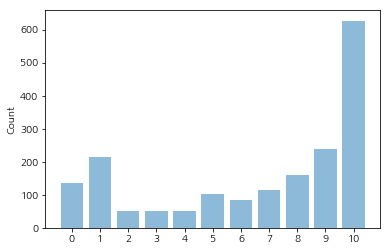

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

score_count_x = [i for i in range(len(score_count))]
score_count_y = [score_count[i] for i in range(len(score_count))]

x_name = [str(i) for i in range(len(score_count))]
y_pos = np.arange(len(x_name))
 
plt.bar(y_pos, score_count_y, align='center', alpha=0.5)
plt.xticks(y_pos, x_name)
plt.ylabel('Count')
 
plt.show()

In [16]:
vocab = list(set(sum(reviews, [])))
len(vocab)

5980

In [17]:
print(vocab[:10])

['나아지나/Verb', '만들려고/Verb', '텅/Noun', '던지더라구요/Verb', '곁/Noun', '마이너스/Noun', '연상/Noun', '움직이냐/Verb', '녕화/Noun', '분이라면/Verb']


#### 2.3 Word_Indexing

In [18]:
# word = key, index = value인 dictionary를 생성합니다.
word2ix = {"<PAD>":0, "<UNK>":1}
for i, v in enumerate(vocab):
    word2ix[v] = i+2
word2ix

{'<PAD>': 0,
 '<UNK>': 1,
 '나아지나/Verb': 2,
 '만들려고/Verb': 3,
 '텅/Noun': 4,
 '던지더라구요/Verb': 5,
 '곁/Noun': 6,
 '마이너스/Noun': 7,
 '연상/Noun': 8,
 '움직이냐/Verb': 9,
 '녕화/Noun': 10,
 '분이라면/Verb': 11,
 '자가/Noun': 12,
 '속편/Noun': 13,
 '넘어/Verb': 14,
 '그루트/Noun': 15,
 '쌩뚱맞/Noun': 16,
 '갤/Verb': 17,
 '해안가/Noun': 18,
 '난다는/Verb': 19,
 '소름끼치는/Verb': 20,
 '블랙/Noun': 21,
 '된다니/Verb': 22,
 '죽는줄/Verb': 23,
 '그리움/Noun': 24,
 '마리/Noun': 25,
 '보시되/Verb': 26,
 '반드시/Noun': 27,
 '빠질게/Verb': 28,
 '안하나요/Verb': 29,
 '포함/Noun': 30,
 '승가/Noun': 31,
 '해드리기로/Verb': 32,
 '저장/Noun': 33,
 '뽀르놀보시/Noun': 34,
 '전체/Noun': 35,
 '!!!/Punctuation': 36,
 '간만/Noun': 37,
 '쫄기했어/Noun': 38,
 '이어지고/Verb': 39,
 '되어서/Verb': 40,
 '다신/Verb': 41,
 '헤헷/Exclamation': 42,
 '깨작/Noun': 43,
 '느냐가/Verb': 44,
 '죽어서/Verb': 45,
 '않네용/Verb': 46,
 '바라보는데/Verb': 47,
 '잡고/Noun': 48,
 '컬러/Noun': 49,
 '볼륨/Noun': 50,
 '날까/Verb': 51,
 '않고도/Verb': 52,
 '수작/Noun': 53,
 '맞기고/Verb': 54,
 '떠나간/Verb': 55,
 '오르는/Verb': 56,
 '지어주니/Verb': 57,
 '도감/Noun': 58,
 '움/No

In [19]:
# index = key, word = value인 dictionary를 생성합니다.

ix2word = {word2ix[k]:k for k in word2ix.keys()}
ix2word

{0: '<PAD>',
 1: '<UNK>',
 2: '나아지나/Verb',
 3: '만들려고/Verb',
 4: '텅/Noun',
 5: '던지더라구요/Verb',
 6: '곁/Noun',
 7: '마이너스/Noun',
 8: '연상/Noun',
 9: '움직이냐/Verb',
 10: '녕화/Noun',
 11: '분이라면/Verb',
 12: '자가/Noun',
 13: '속편/Noun',
 14: '넘어/Verb',
 15: '그루트/Noun',
 16: '쌩뚱맞/Noun',
 17: '갤/Verb',
 18: '해안가/Noun',
 19: '난다는/Verb',
 20: '소름끼치는/Verb',
 21: '블랙/Noun',
 22: '된다니/Verb',
 23: '죽는줄/Verb',
 24: '그리움/Noun',
 25: '마리/Noun',
 26: '보시되/Verb',
 27: '반드시/Noun',
 28: '빠질게/Verb',
 29: '안하나요/Verb',
 30: '포함/Noun',
 31: '승가/Noun',
 32: '해드리기로/Verb',
 33: '저장/Noun',
 34: '뽀르놀보시/Noun',
 35: '전체/Noun',
 36: '!!!/Punctuation',
 37: '간만/Noun',
 38: '쫄기했어/Noun',
 39: '이어지고/Verb',
 40: '되어서/Verb',
 41: '다신/Verb',
 42: '헤헷/Exclamation',
 43: '깨작/Noun',
 44: '느냐가/Verb',
 45: '죽어서/Verb',
 46: '않네용/Verb',
 47: '바라보는데/Verb',
 48: '잡고/Noun',
 49: '컬러/Noun',
 50: '볼륨/Noun',
 51: '날까/Verb',
 52: '않고도/Verb',
 53: '수작/Noun',
 54: '맞기고/Verb',
 55: '떠나간/Verb',
 56: '오르는/Verb',
 57: '지어주니/Verb',
 58: '도감/Noun',
 59: '

In [20]:
reviews_ix = []

for review in reviews:
    if len(review) != 0:
        seq = []
        for word in review:
            seq.append(word2ix[word]) # word의 index로 구성된 reviews_ix 리스트를 생성합니다.
    else:
        seq = []
        seq.append(word2ix["<UNK>"])
    reviews_ix.append(seq)

In [21]:
reviews_ix[0:5]

[[1512, 2279, 1491, 4296],
 [5430, 4915, 1379, 2242, 2079, 5469, 3440, 1571, 3356, 1554, 4781, 2255],
 [657, 4444, 2946],
 [2946, 5362, 4215],
 [3332, 5208, 1029]]

In [22]:
len(reviews_ix)

1827

In [23]:
# Max Sequence Length
max_seq_length = max([len(seq) for seq in reviews_ix])
print(max_seq_length)

# Min Sequence Length
min_seq_length = min([len(seq) for seq in reviews_ix])
print(min_seq_length)

113
1


## 3. Save Data with Pickle

In [24]:
# pickle 확장자로 저장해서 나중에 불러오기 편하게 만들어줍니다.
import pickle

save_data = {
    "reviews": reviews,
    "scores": score,
    "reviews_ix": reviews_ix,
    "word2ix": word2ix,
    "ix2word": ix2word,
    "max_seq_length": max_seq_length
}

with open("movie_data.pickle", "wb") as f:
    pickle.dump(save_data, f)